---
# <font color="DarkBlue"><b><center>Escuela Politécnica Nacional</center></b></font>
---
## <font color="DarkGreen"><center>Ransomware dynamics: Mitigating personal data exfiltration through the SCIRAS lens</font>

## <font color="DarkGreen"><center>Deep Neural Network</font>

**Author:** David Cevallos-Salas, José Estrada-Jiménez, Danny S. Guamán, Luis Felipe Urquiza

**Date:** 2024-10-17

**Google Colab Link:**
https://colab.research.google.com/drive/1IuxYqh7qNsIelt6-Ysz2ePAdhTynngGf

In [ ]:
# Importing libraries
from os import X_OK
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.utils import to_categorical,plot_model
from sklearn.pipeline import Pipeline as skPipeline
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split
import sklearn.metrics as mt
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import os

# Import Keras Wrapper connector
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

from scikeras.wrappers import KerasClassifier

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!git clone https://github.com/dcevallossalas/sanrap_sciras4

node = "win7"
y = np.array([])
first = True
first1 = True

families = os.listdir("/content/sanrap_sciras4/" + node + "/")

for family in families:
  annotations = os.listdir("/content/sanrap_sciras4/" + node + "/" + family)
  for annotation in annotations:
    files =  os.listdir("/content/sanrap_sciras4/" + node + "/" + family + "/" + annotation)
    for file in files:
      zipped = False
      if file.endswith(".zip"):
        zipped = True
        path1 = "/content/sanrap_sciras4/" + node + "/" + family + "/" + annotation + "/" + file
        path2 = "/home"
        with zipfile.ZipFile(path1, 'r') as zip_ref:
          zip_ref.extractall(path2)

        file = file.replace(".zip",".csv")

      if file.endswith("write.csv"):
        if zipped:
          data = pd.read_csv(path2 + "/original/win7-120gb-ssd/"+ family + "/" + annotation+"/" + file)
        else:
          data = pd.read_csv("/content/sanrap_sciras4/" + node + "/" + family + "/" + annotation+"/" + file)

        x1 = data.drop(data.columns[0],axis=1).to_numpy()

        if first:
          x = x1
          first = False
        else:
          x = np.concatenate((x,x1))

        n = len(x1)

        if annotation.startswith("TeslaCrypt"):
          code = 1
        elif annotation.startswith("WannaCry"):
          code = 2
        elif annotation.startswith("Cerber"):
          code = 3
        elif annotation.startswith("Gand"):
          code = 4
        elif annotation.startswith("Ryuk"):
          code = 5
        elif annotation.startswith("Sodi"):
          code = 6
        elif annotation.startswith("Dark"):
          code = 7
        else:
          code = 0

        if first1:
          y = np.full(n,code)
          first1 = False
        else:
          y = np.concatenate((y,np.full(n,code)))

# Definition of labels
labels = [
    "Benign",
    "TeslaCrypt",
    "WannaCry",
    "Cerber",
    "GandCrab-v4",
    "Ryuk",
    "Sodinokibi",
    "Darkside"
]

# Number of categories
num_classes = 8

# Visualize general shapes on screen
print("Shape x (features):", x.shape)
print("Shape y (families labels): ", y.shape)


Cloning into 'sanrap_sciras4'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 384 (delta 1), reused 130 (delta 1), pack-reused 254 (from 1)
Receiving objects: 100% (384/384), 1.03 GiB | 18.04 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Updating files: 100% (240/240), done.
Shape x (features): (56410988, 5)
Shape y (families labels):  (56410988,)


In [ ]:
x, x2, y, y2 = train_test_split(x, y, train_size=0.06, shuffle=True, random_state = 1234, stratify=y)

# Splitting (training and test balanced sets definitions)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, shuffle=True, random_state = 1234, stratify = y)

# Number of metrics
num_metrics = 8

In [ ]:
# ----------------------------------------------------------------------------
# Function for generating Keras model
# ----------------------------------------------------------------------------
def generateModel(num_hidden_layers=1, num_neurons= 32, regularization="l1", lambda_value=1, num_features=1, num_classes=1):
  model = keras.Sequential()

  for i in np.arange(1,num_hidden_layers+1):
    # Regularization
    if (regularization=="l1"):
      kernel_regularizer=keras.regularizers.L1(lambda_value)
    else:
      kernel_regularizer=keras.regularizers.L2(lambda_value)

    # First hidden layer includes features input
    if (i == 1):
      model.add(keras.layers.Dense(units=num_neurons, input_shape=(num_features,), kernel_regularizer=kernel_regularizer))
    else:
      model.add(keras.layers.Dense(units=num_neurons, kernel_regularizer=kernel_regularizer))

    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.Dropout(0.01))

  # Output layer
  model.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_regularizer=kernel_regularizer))

  # Return model
  return model

# ----------------------------------------------------------------------------
# Define model and pipeline
# Return tuned pipeline
# ----------------------------------------------------------------------------
def simulate(x_train, y_train, num_classes, smote=False, hidden_layers_value=None, lambda_value=None, batching=32):
  # General random seeds for experiment reproducibility
  np.random.seed(1)
  tf.random.set_seed(1)
  tf.keras.utils.set_random_seed(1)

  # Hyperaparameter and fixed values
  if hidden_layers_value is None:
    num_hidden_layers = [3]
  else:
    num_hidden_layers = [hidden_layers_value]

  num_neurons = [128]
  epochs = [10]
  batchs = [batching]
  regularization = ["l2"]

  if lambda_value is None:
    lambdas = [1e-6]
  else:
    lambdas = [lambda_value]

  # Keras wrapper
  clf = KerasClassifier(
    model = generateModel,
    loss= "sparse_categorical_crossentropy",
    metrics= ["acc"],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    batch_size=batchs,
    epochs=epochs,
    num_hidden_layers = num_hidden_layers,
    num_neurons = num_neurons,
    regularization = regularization,
    lambda_value = lambdas,
    num_features=x_train.shape[1],
    num_classes=num_classes,
  )

  if smote:
    pipeline = imbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("scaler", StandardScaler()),
        ("clf", clf)
    ])
  else:
    pipeline = skPipeline([
        ("scaler", StandardScaler()),
        ("clf", clf)
    ])

  # Repeated kfold cross validation definition
  rkfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=45)

  # Parameters of grid
  param_grid = {
                "clf__num_hidden_layers": num_hidden_layers,
                "clf__num_neurons": num_neurons,
                "clf__epochs":epochs,
                "clf__batch_size":batchs,
                "clf__regularization": regularization,
                "clf__lambda_value": lambdas,
              }

  # GridSearchCV
  search = GridSearchCV(pipeline, param_grid, cv=rkfold, verbose=4)

  result = search.fit(x_train, y_train)

  # Training with best hyperparameters
  pipeline.set_params(
    clf__num_hidden_layers=result.best_params_["clf__num_hidden_layers"],
    clf__num_neurons = result.best_params_["clf__num_neurons"],
    clf__epochs= result.best_params_["clf__epochs"],
    clf__batch_size= result.best_params_["clf__batch_size"],
    clf__regularization=result.best_params_["clf__regularization"],
    clf__lambda_value= result.best_params_["clf__lambda_value"]
    )

  print(f"Best result at validation set: {result.best_score_} with hyperparameters {result.best_params_}")

  print("Retraining:")
  pipeline.fit(x_train, y_train)
  return pipeline

# ----------------------------------------------------------------------------
# Present results
# Present results on screen
# ----------------------------------------------------------------------------
def visualizeResults(x_test, y_test, pipeline):
  # Test evaluation
  y_test_pred_proba = pipeline.predict_proba(x_test)

  y_test_pred = pipeline.predict(x_test)
  f1score = mt.f1_score(y_test, y_test_pred, average="weighted")
  acc = mt.accuracy_score(y_test, y_test_pred)
  preci = mt.precision_score(y_test, y_test_pred, average="weighted")
  recall = mt.recall_score(y_test, y_test_pred, average="weighted")

  # Classification report
  print("Classification report")
  report = mt.classification_report(y_test, y_test_pred)
  print(report)

  cm = mt.confusion_matrix(y_test, y_test_pred)
  pd_cm = pd.DataFrame(cm,
             columns=labels,
             index=labels)

  # Display confusion matrix using Heat Map
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax,
    square=True,
    cmap="Blues",
    linewidths=0.2,
    annot_kws={"fontsize":5.5})
  ax.set_xlabel("Predicted values", fontsize=8)
  ax.set_ylabel("True values", fontsize=8)
  ax.xaxis.set_ticklabels(labels, fontsize=8)
  ax.yaxis.set_ticklabels(labels, fontsize=8)
  cbar = ax.collections[0].colorbar
  cbar.ax.tick_params(labelsize=8)
  plt.yticks(rotation=0)
  plt.xticks(rotation=90)

  # ROC curves
  import colorcet as cc

  palette = sns.color_palette(cc.glasbey, num_classes)
  palette1 = sns.color_palette(cc.glasbey, 16)
  palette[0] = palette1[10]
  palette[1] = palette1[0]

  t_test_oneh = to_categorical(y_test,num_classes)
  fig, ax = plt.subplots()
  auc = 0

  for i in np.arange(0,num_classes):
    fpr, tpr, thresholds = mt.roc_curve(t_test_oneh[:, i], y_test_pred_proba[:, i])
    auc_value = round(mt.auc(fpr, tpr),4)
    auc = auc+auc_value
    plt.plot(fpr, tpr,color=palette[i],label=labels[i] + " (AUC="+str(auc_value)+")")

  plt.plot([0,1],[0,1],"k--")
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="best", prop={'size': 6})
  plt.grid()
  plt.show()

  auc = auc/num_classes

  # Test evaluation results
  print("Test evaluation results: recall =", recall, ", F1 =", f1score, ", acc =", acc, ", precision =", preci, "auc =", auc)


In [ ]:
# Build model without SMOTE on training data
pipeline = simulate(x_train, y_train, num_classes, smote=False, batching=512)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Epoch 1/10
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 63s 14ms/step - acc: 0.7370 - loss: 0.7136
Epoch 2/10
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 85s 15ms/step - acc: 0.7627 - loss: 0.6221
Epoch 3/10
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 59s 14ms/step - acc: 0.7697 - loss: 0.6017
Epoch 4/10
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 59s 14ms/step - acc: 0.7758 - loss: 0.5845
Epoch 5/10
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - acc: 0.7828 - loss: 0.5642
Epoch 6/10
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 60s 14ms/step - acc: 0.7868 - loss: 0.5528
Epoch 7/10
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 59s 14ms/step - acc: 0.7891 - loss: 0.5460
Epoch 8/10
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 85s 15ms/step - acc: 0.7908 - loss: 0.5401
Epoch 9/10
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 61s 14ms/step - acc: 0.7928 - loss: 0.5356
Epoch 10/10
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - acc: 0.7943 - loss: 0.5307
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
[CV 1/10] END clf__batch_size=512, clf__epoch

-------------------------------------------------------------------------
8-Classes Classifier results without SMOTE Batching 512
-------------------------------------------------------------------------
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Classification report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95    451299
           1       0.43      0.23      0.30     10632
           2       0.73      0.78      0.76     59631
           3       0.69      0.32      0.44     14676
           4       0.43      0.62      0.51     43710
           5       0.38      0.43      0.41     37602
           6       0.33      0.18      0.23     33382
           7       0.28      0.28      0.28     26000

    accuracy                           0.80    676932
   macro avg       0.53      0.47      0.48    676932
weighted avg       0.80      0.80      0.79    676932



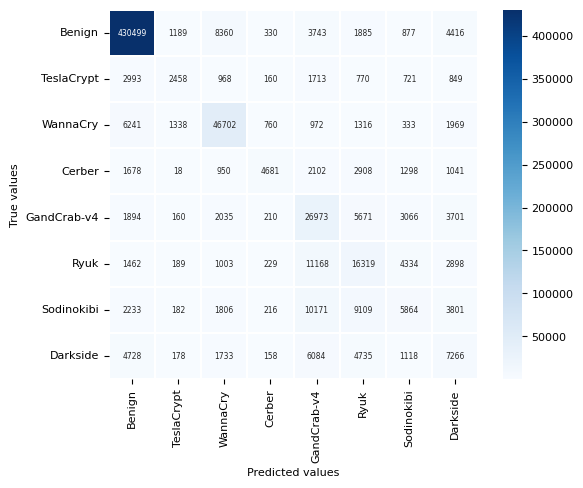

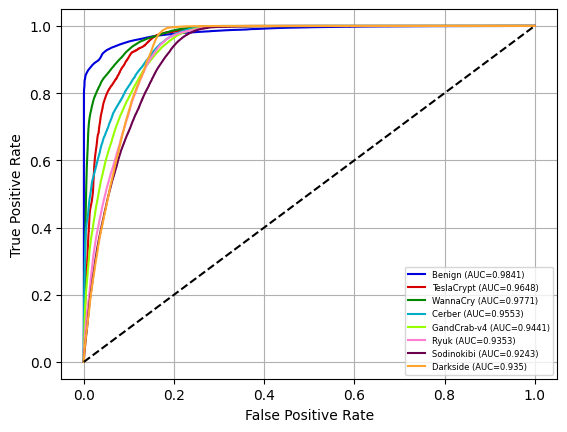

Test evaluation results: recall = 0.7988424243498609 , F1 = 0.7939722362635346 , acc = 0.7988424243498609 , precision = 0.7979669436845037 auc = 0.9524999999999999


In [ ]:
# Visualize results obtained
print("-------------------------------------------------------------------------")
print(str(num_classes) + "-Classes Classifier results without SMOTE Batching 512")
print("-------------------------------------------------------------------------")
visualizeResults(x_test, y_test, pipeline)